In [3]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [34]:
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Found CUDA-enabled device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [19]:
class TorchVisionDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform
        self.corrupted_count = 0

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        try:
            image = Image.open(file_path)

            if image.mode == 'RGBA':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            self.corrupted_count += 1
            print(self.corrupted_count)
            return torch.zeros(3, 224, 224), label

In [20]:
images = glob.glob("data/*/*/*")
images = np.array(images)
labels = np.array([f.split("\\")[-2] for f in images])

print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

12000
12000
data\Test\Black\air_freshener_container_2.png
Black


In [21]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype = np.int64)
print(labels_int.shape)

for ii,jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['Black' 'Blue' 'Green' 'TTR']
(12000,)
Label  0 : 2483
Label  1 : 5124
Label  2 : 2343
Label  3 : 2050


In [ ]:
for ii in range(4):
    print("Label ", ii, ":", (labels_int == ii).sum())

In [22]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss.get_n_splits(images,labels_int)
dev_index, test_index = next(sss.split(images,labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [23]:
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 


In [24]:
print("Train set:", len(train_images))
print("Val set:", len(val_images))
print("Test set:", len(test_images))

Train set: 7680
Val set: 1920
Test set: 2400


In [ ]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [25]:
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])

In [26]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [27]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, num_workers= 0)

In [28]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

(tensor([0.1344, 0.1644, 0.2007]), tensor([0.9934, 1.0172, 1.0492]))


In [ ]:

print(get_dataset_stats(trainloader))

In [29]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:

print(train_batch[0].size())
print(train_batch[1].size())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


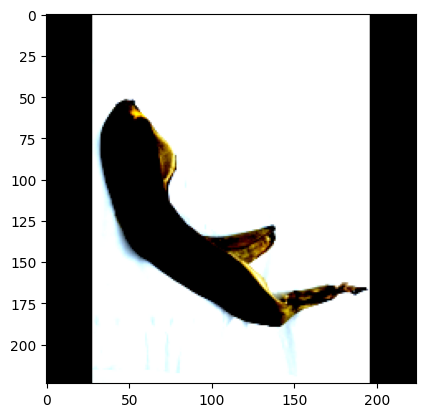

In [30]:
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [35]:
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet18(pretrained=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
              
       return x

In [ ]:
net = GarbageModel(4, (3,224,224), False)
net.to(device)

In [37]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [39]:
nepochs = 20
PATH = './garbage_net.pth' # Path to save the best model
best_loss = 1e+20

for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i + 1):.3f}') 
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

In [ ]:
net = GarbageModel(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')